$$ \Huge Autoencoders $$ 

# Introduction

✔︎ Autoencoders are a specific type of **feedforward neural networks** where the **input is the same as the output**   
✔︎  They **compress the input** into a **lower-dimensional code** and **then reconstruct the output** from this representation. 

> The **code** is a compact **“summary”** or **“compression”** of the **input**, also called the **latent-space representation.**

✔︎  **An autoencoder consists of 3 components:**   
     $\qquad$☛ **Encoder:**  compresses the input and produces the code   
     $\qquad$☛ **Code**   
     $\qquad$☛ **Decoder:** reconstructs the input only using this code

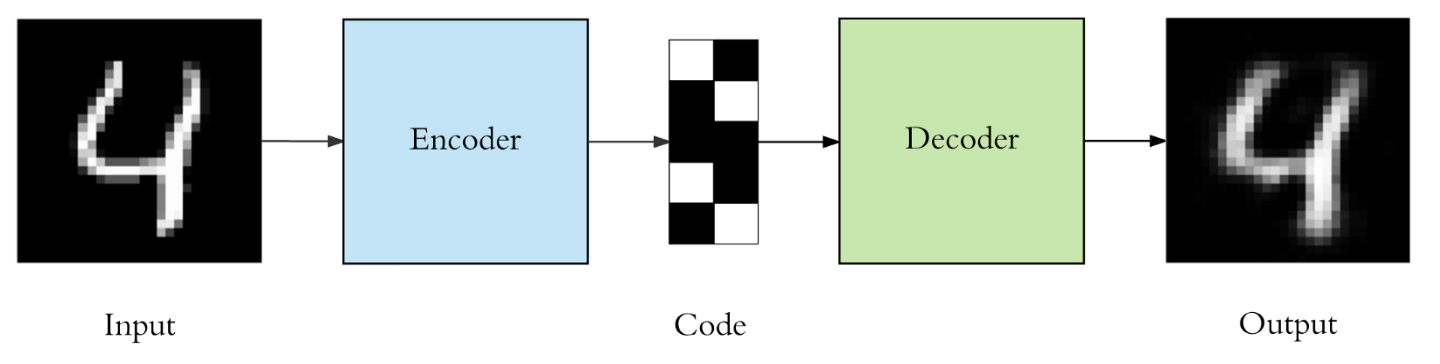

✔︎ **To build an autoencoder we need 3 things:**   
$\qquad$☛ Encoding method  
$\qquad$☛ Decoding method  
$\qquad$☛ Loss function to compare the output with the target

✔︎ **Autoencoders are mainly a dimensionality reduction (or compression) algorithm with a couple of important properties:**

$\qquad$☛  **Data-specific:** Autoencoders are only able to meaningfully **compress data similar to what they have been trained on**. Since they **learn features specific for the given training data**, they are **different than a standard data compression algorithm like gzip**. 

$\qquad$☛ **Lossy:** The **output** of the autoencoder will **not be exactly the same as the input**, it will be a close but degraded representation. If you want lossless compression they are not the way to go.

$\qquad$☛ **Unsupervised:** To train an autoencoder we don’t need to do anything fancy, just throw the raw input data at it. Autoencoders are considered an unsupervised learning technique since they **don’t need explicit labels to train on.** But to be more precise they are self-supervised because **they generate their own labels from the training data.**

# Architecture

✔︎ Both the **encoder and decoder** are **fully-connected** feedforward neural networks   
✔︎ **Code** is a **single layer** of an ANN with the **dimensionality of our choice**   
✔︎ The **number of nodes** in the code layer (code size) is a **hyperparameter** that we **set before training** the autoencoder.

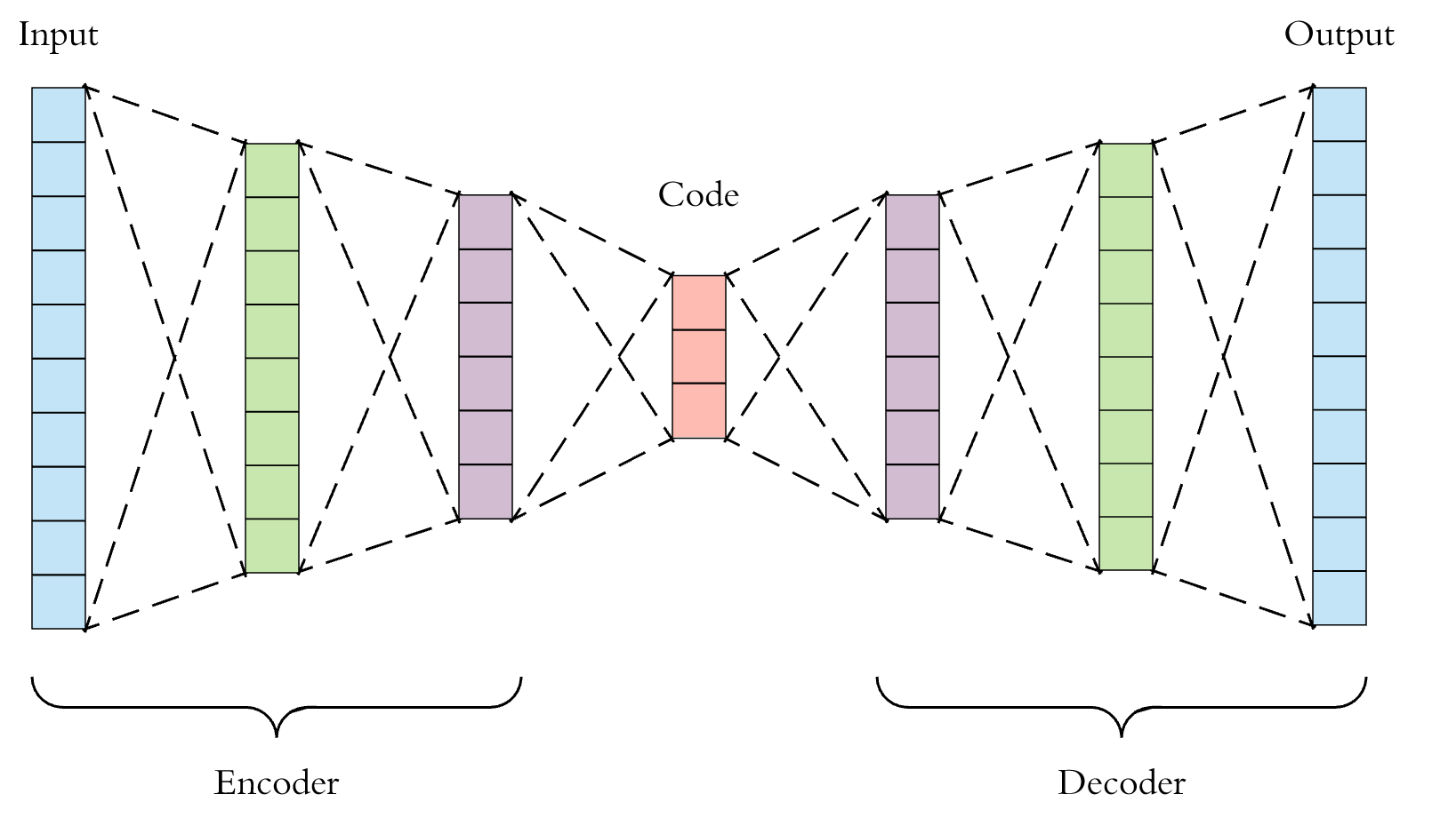

✔︎  This is a more detailed visualization of an autoencoder

$\qquad$ $\Large❶$ First the input passes through the encoder, which is a fully-connected ANN, to produce the code.  

$\qquad$ $\Large❷$ The decoder then produces the output only using the code.
> **The goal is to get an output identical with the input**

✔︎ There are 4 hyperparameters that we need to set before training an autoencoder:

$\qquad$ $\Large❶$ **Code size:** number of nodes in the middle layer. Smaller size results in more compression.

$\qquad$ $\Large❷$ **Number of layers:** the autoencoder can be as deep as we like. In the figure above we have 2 layers in both the encoder and decoder, without considering the input and output.

$\qquad$ $\Large ❸$ **Number of nodes per layer:** The number of nodes per layer decreases with each subsequent layer of the encoder, and increases back in the decoder. Also the decoder is symmetric to the encoder in terms of layer structure.

$\qquad$ $\Large ❹$ **Loss function:** we either use mean squared error (mse) or binary crossentropy. If the input values are in the range [0, 1] then we typically use crossentropy, otherwise we use the mean squared error. For more details check out this [video](https://www.youtube.com/watch?v=xTU79Zs4XKY).

___
 $$ \Large \text {Autoencoders are trained the same way as ANNs via backpropagation. } $$
___

# Implementation

Now let’s implement an autoencoder for the following architecture, **1 hidden layer** in the **encoder** and **decoder.**

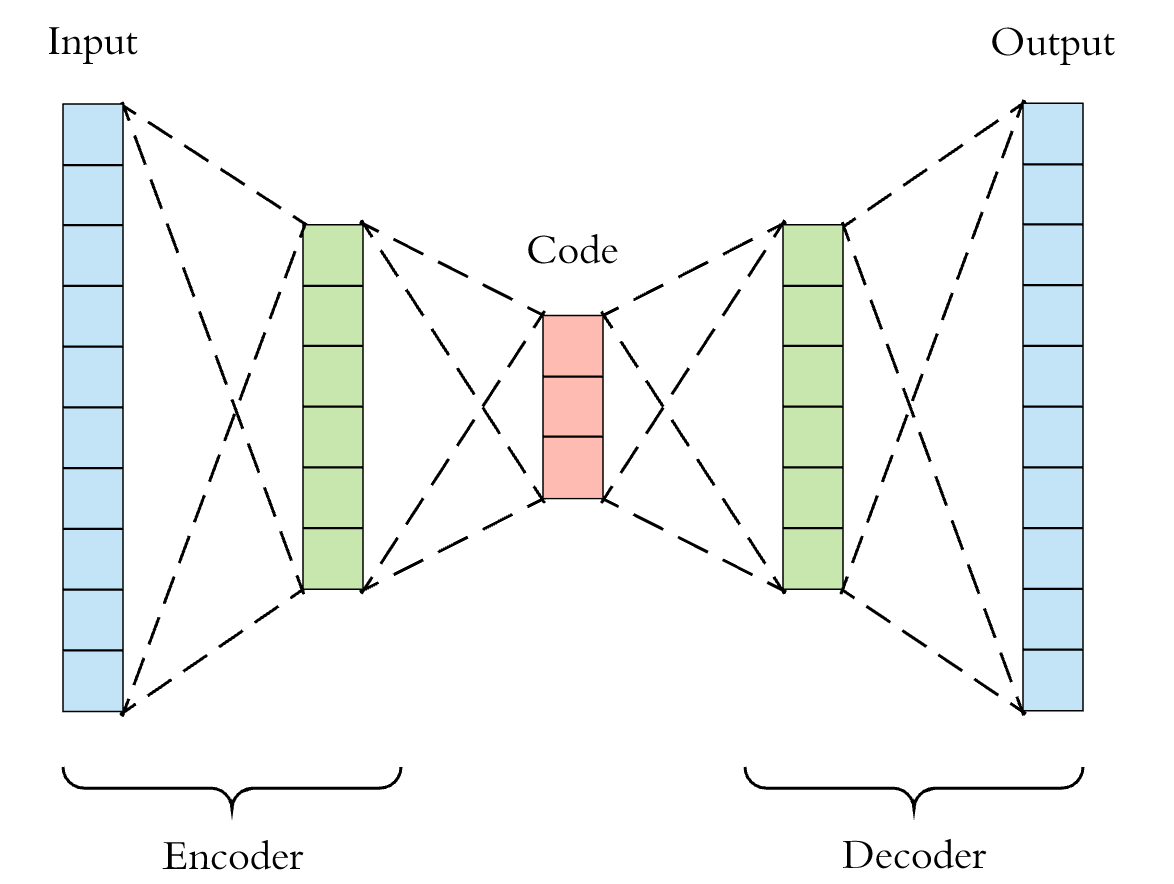

✔︎ **Import library**

In [8]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam

✔︎ **Utility Functions**

In [7]:
#```python
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

#```

✔︎ **MNIST**

* **Deep Autoencoder**

In [15]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [16]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=3)

Epoch 1/3
60000/60000 [==============================] - 14s 240us/step - loss: 0.1367
Epoch 2/3
60000/60000 [==============================] - 14s 237us/step - loss: 0.0980
Epoch 3/3
60000/60000 [==============================] - 14s 231us/step - loss: 0.0922


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation
input_size = 784
hidden_size = 128
code_size = 32

model = Sequential()
model.add(Dense(hidden_size, input_dim=input_size, activation='relu'))
model.add(Dense(code_size, activation='relu'))
model.add(Dense(hidden_size, activation='relu'))
model.add(Dense(input_size, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy')


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
model.fit(x_train, x_train, epochs=3)


Epoch 1/3
60000/60000 [==============================] - 14s 235us/step - loss: 0.1383
Epoch 2/3
60000/60000 [==============================] - 14s 238us/step - loss: 0.0995
Epoch 3/3
60000/60000 [==============================] - 14s 231us/step - loss: 0.0944


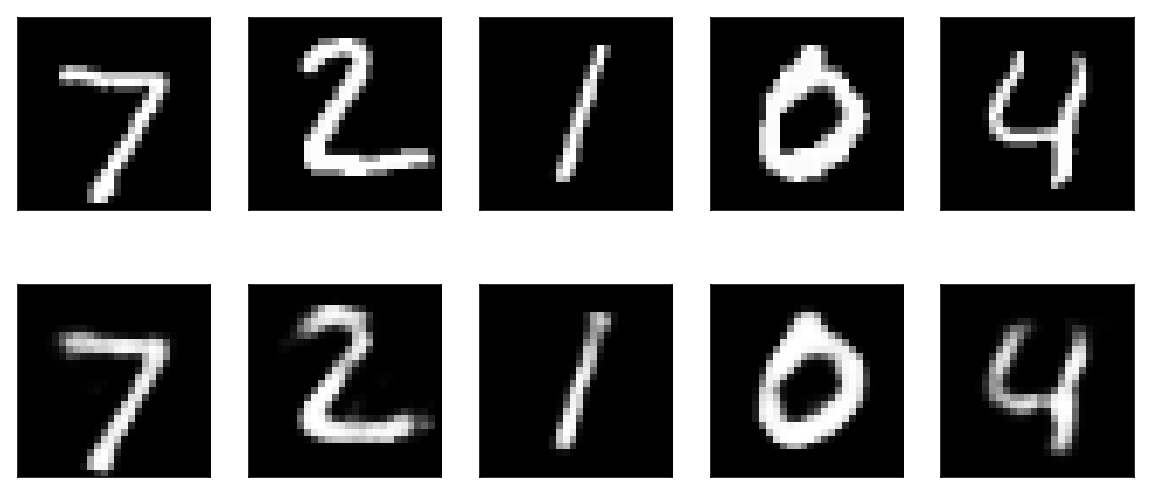

In [17]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

In [31]:
len(autoencoder.get_weights())


8

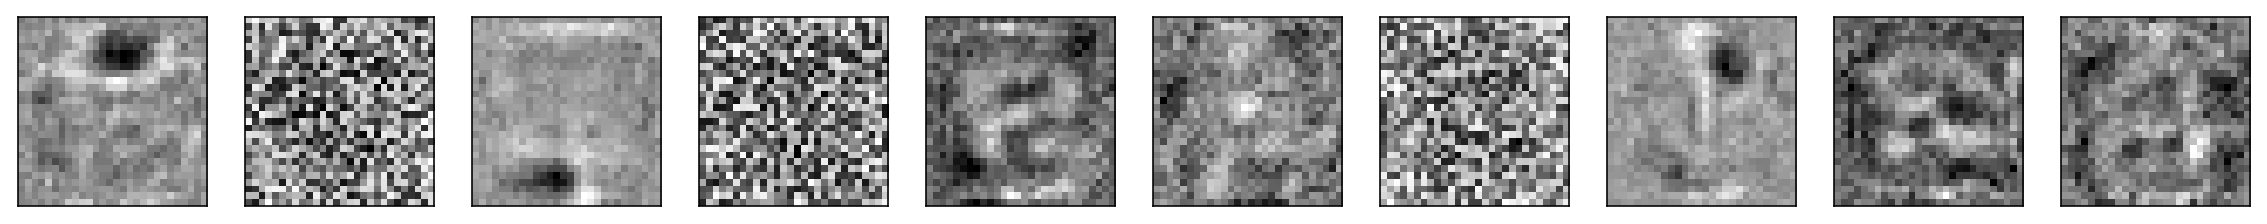

In [18]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+0].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    

* **Shallow Autoencoder**

In [19]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train, epochs=5)

Epoch 1/5
60000/60000 [==============================] - 11s 178us/step - loss: 0.1628
Epoch 2/5
60000/60000 [==============================] - 11s 176us/step - loss: 0.1046
Epoch 3/5
60000/60000 [==============================] - 11s 177us/step - loss: 0.0968
Epoch 4/5
60000/60000 [==============================] - 11s 175us/step - loss: 0.0952
Epoch 5/5
60000/60000 [==============================] - 11s 176us/step - loss: 0.0947


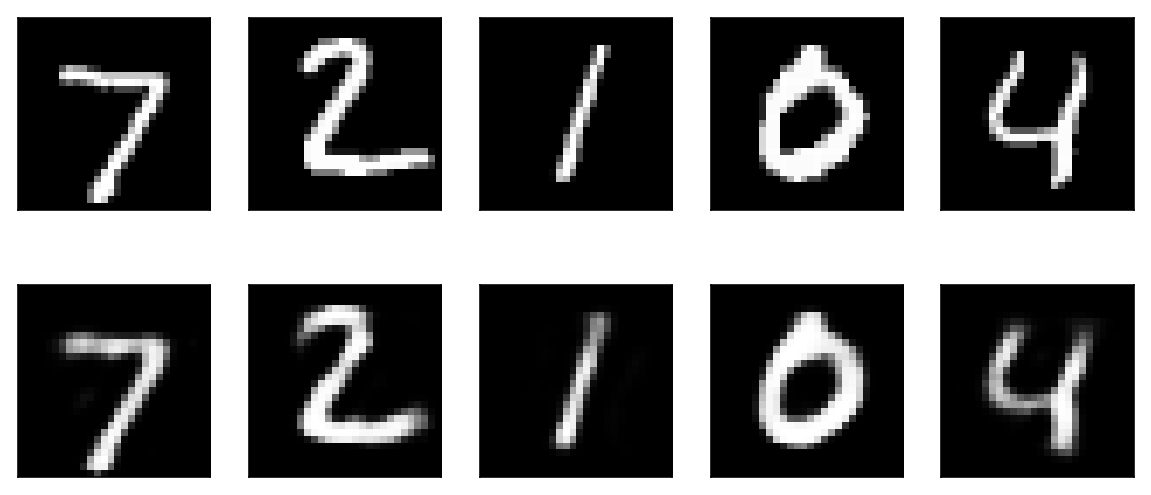

In [20]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))

In [ ]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+20].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Denoising Autoencoders

Keeping the **code layer small** forced our autoencoder to **learn an intelligent representation** of the data.
> There is another way to force the autoencoder to learn useful features, which is adding random noise to its inputs and making it recover the original noise-free data.   

> This way the autoencoder can’t simply copy the input to its output because the input also contains random noise.

___
**We are asking it to subtract the noise and produce the underlying meaningful data. This is called a denoising autoencoder.**
___

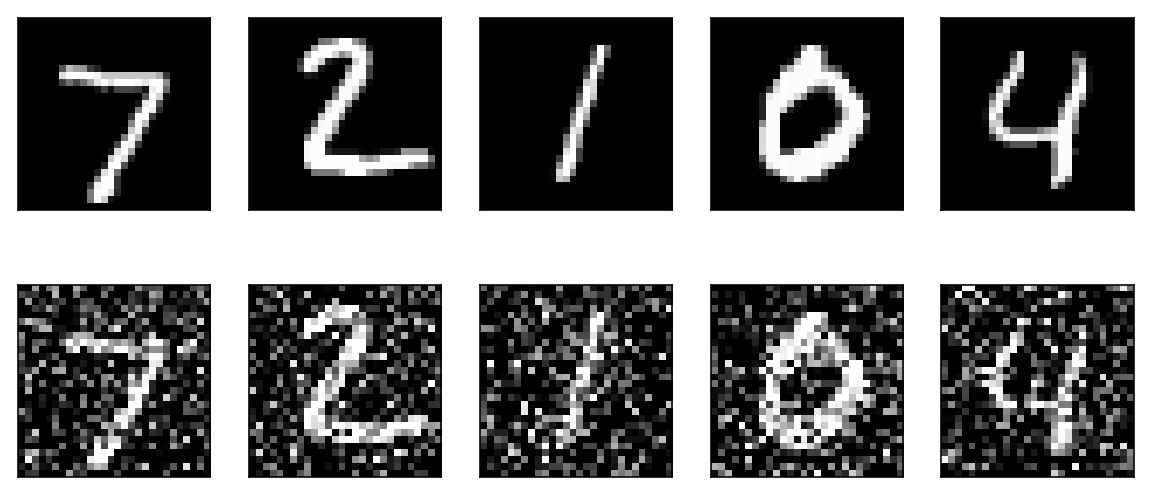

In [21]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)

n = 5
plt.figure(figsize=(10, 4.5))
for i in range(n):
    # plot original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')

The top row contains the original images. We **add random Gaussian noise** to them and the noisy data becomes the input to the autoencoder.

The autoencoder doesn’t see the original image at all. But then we expect the autoencoder to regenerate the noise-free original image.

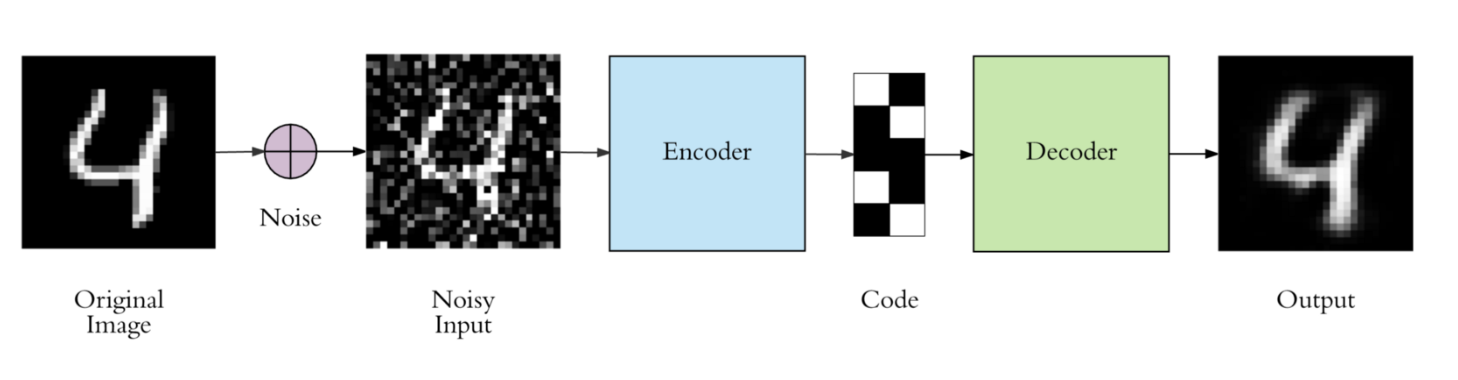

In [22]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train_noisy, x_train, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 15s 245us/step - loss: 0.1637
Epoch 2/10
60000/60000 [==============================] - 14s 241us/step - loss: 0.1272
Epoch 3/10
60000/60000 [==============================] - 14s 236us/step - loss: 0.1202
Epoch 4/10
60000/60000 [==============================] - 15s 242us/step - loss: 0.1165
Epoch 5/10
60000/60000 [==============================] - 14s 237us/step - loss: 0.1144
Epoch 6/10
60000/60000 [==============================] - 14s 229us/step - loss: 0.1129
Epoch 7/10
60000/60000 [==============================] - 14s 233us/step - loss: 0.1119
Epoch 8/10
60000/60000 [==============================] - 15s 242us/step - loss: 0.1110
Epoch 9/10
60000/60000 [==============================] - 14s 236us/step - loss: 0.1103
Epoch 10/10
60000/60000 [==============================] - 14s 233us/step - loss: 0.1097


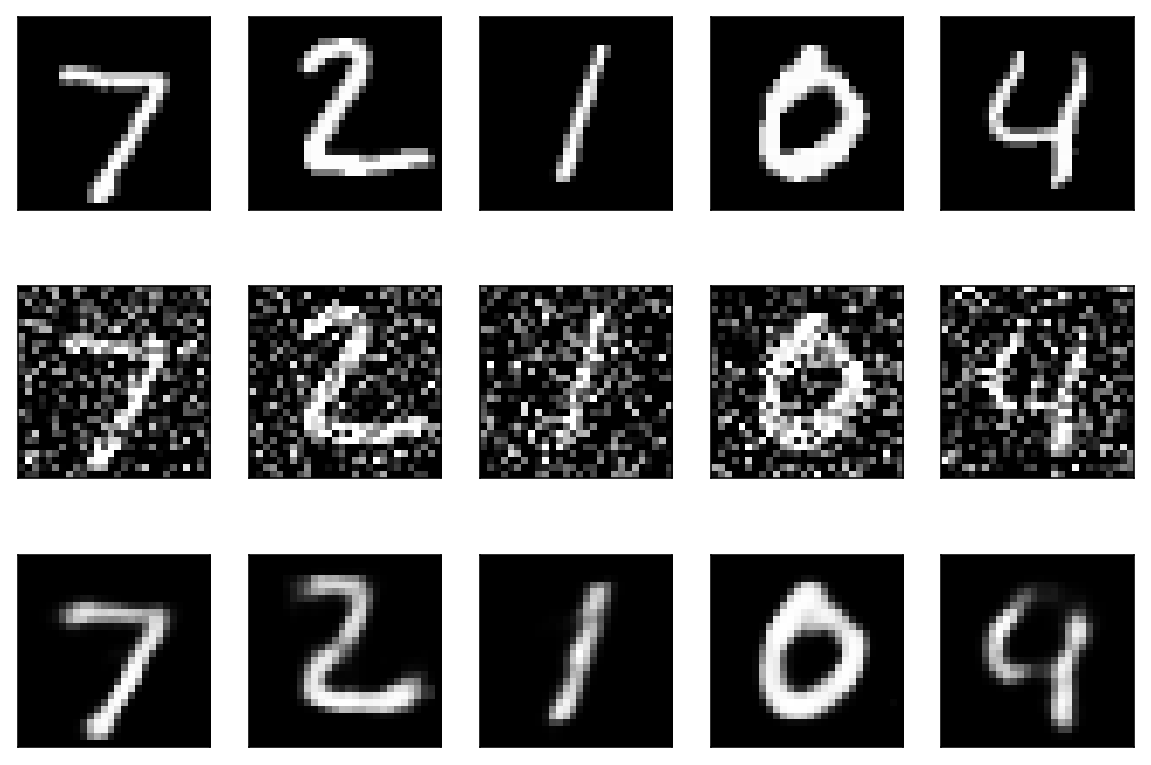

In [23]:
n = 5
plt.figure(figsize=(10, 7))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')

# Sparse Autoencoders

* We introduced two ways to force the autoencoder to learn useful features: 
    * keeping the code size small 
    * and denoising autoencoders. 
   
* The third method is using regularization. 
    * We can regularize the autoencoder by using a **sparsity constraint** such that **only a fraction of the nodes would have nonzero values,** called active nodes.

✔︎  We **add a penalty term** to the **loss function**

* Previously we created the code layer

___
``` python
code = Dense(code_size, activation='relu')(input_img)
```
___

✔︎  **We now add another parameter called $activity\_regularizer $**

___
```python
code = Dense(code_size, activation='relu', activity_regularizer=l1(10e-6))(input_img)
```
___

In [ ]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_standard = Model(input_img, output_img)
autoencoder_standard.compile(optimizer='adam', loss='binary_crossentropy')
history_standard = autoencoder_standard.fit(x_train, x_train, epochs=20)

encoded_standard = Model(input_img, code)

Epoch 1/20
60000/60000 [==============================] - 11s 187us/step - loss: 0.1621
Epoch 2/20
60000/60000 [==============================] - 11s 180us/step - loss: 0.1046
Epoch 3/20
60000/60000 [==============================] - 10s 174us/step - loss: 0.0965
Epoch 4/20
60000/60000 [==============================] - 10s 175us/step - loss: 0.0949
Epoch 5/20
60000/60000 [==============================] - 11s 177us/step - loss: 0.0944
Epoch 6/20
60000/60000 [==============================] - 11s 181us/step - loss: 0.0941
Epoch 7/20
60000/60000 [==============================] - 11s 179us/step - loss: 0.0939
Epoch 8/20
60000/60000 [==============================] - 11s 178us/step - loss: 0.0938
Epoch 9/20
60000/60000 [==============================] - 10s 174us/step - loss: 0.0937
Epoch 10/20
60000/60000 [==============================] - 11s 176us/step - loss: 0.0936
Epoch 11/20
60000/60000 [==============================] - 11s 176us/step - loss: 0.0935
Epoch 12/20
60000/60000 [=====

In [ ]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu', activity_regularizer=l1(10e-6))(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_regularized = Model(input_img, output_img)
autoencoder_regularized.compile(optimizer='adam', loss='binary_crossentropy')
history_regularized = autoencoder_regularized.fit(x_train, x_train, epochs=20)

encoded_regularized = Model(input_img, code)

In [ ]:
plot_autoencoder_outputs(autoencoder_regularized, 5, (28, 28))

In [ ]:
plot_compare_histories([history_standard, history_regularized], 
                       ['Standard Autoencoder', 'Regularized Autoencoder'], plot_accuracy=False)

In [ ]:
autoencoder_standard.evaluate(x_test, x_test)

In [ ]:
autoencoder_regularized.evaluate(x_test, x_test)

In [ ]:
print(encoded_standard.predict(x_test).mean())
print(encoded_regularized.predict(x_test).mean())

In [ ]:
standard_scores = encoded_standard.predict(x_test).ravel()
regularized_scores = encoded_regularized.predict(x_test).ravel()
sns.distplot(standard_scores, hist=False, label='standard model')
sns.distplot(regularized_scores, hist=False, label='regularized model')

In [ ]:
sns.distplot(regularized_scores, hist=False, label='regularized model')

# Use Cases

✔︎  **They have 3 common use cases though:**

$\qquad$☛ **Denoising:** we have seen an example of this on images.

$\qquad$☛ **Dimensionality reduction:** visualizing high-dimensional data is challenging. t-SNE is the most commonly used method but struggles with large number of dimensions (typically above 32). So autoencoders are used as a preprocessing step to reduce the dimensionality, and this compressed representation is used by t-SNE to visualize the data in 2D space. For great articles on t-SNE refer here and here.

$\qquad$☛ **Variational Autoencoders (VAE):** this is a more modern and complex use-case of autoencoders and we will cover them in another article. But as a quick summary, VAE learns the parameters of the probability distribution modeling the input data, instead of learning an arbitrary function in the case of autoencoders.

# Conclusion

Autoencoders are a very useful dimensionality reduction technique. 